In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [3]:
# We import the model
model = WCModel()

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 100.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,:] = 0.7
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]

# We set the duration of the simulation and the initial values
model.params["duration"] = duration

# We set the stimulus in x and y variables, and run the simulation
model.params["exc_ext"] = input
model.params["inh_ext"] = zero_input
model.params.exc_init = np.array([[0.17258623779163518]])
model.params.exc_init = np.array([[0.07601243884401115]])
model.run()
te = model.exc[0,-1]
ti = model.inh[0,-1]

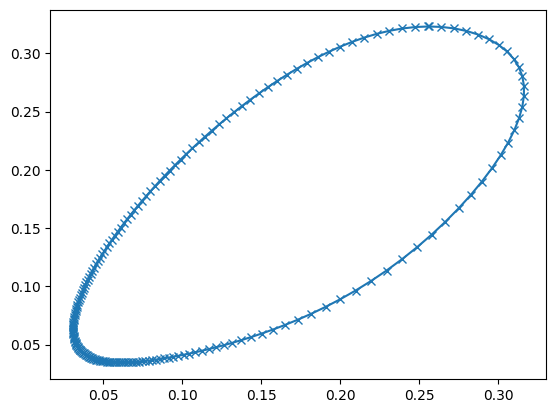

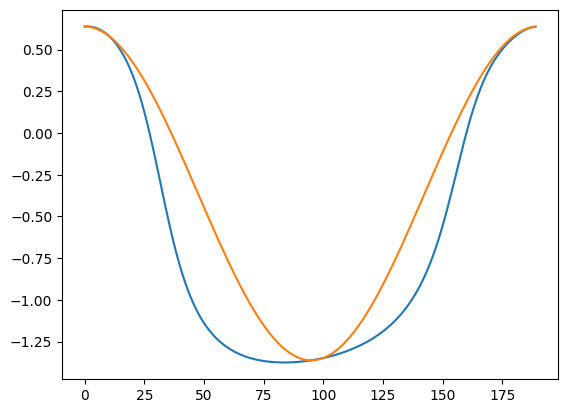

84 95


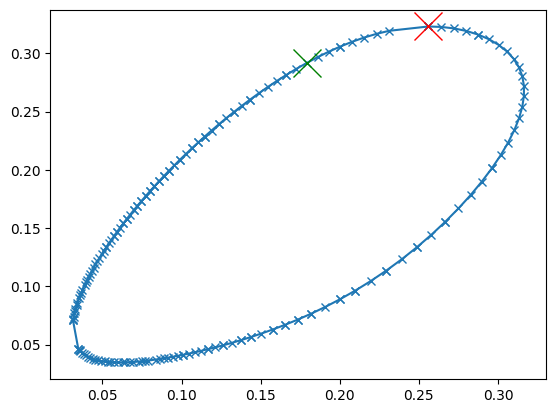

In [4]:
# We import the model
model = WCModel()

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 100.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,:] = 1.
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]

# We set the duration of the simulation and the initial values
model.params["duration"] = duration

# We set the stimulus in x and y variables, and run the simulation
model.params["exc_ext"] = input
model.params["inh_ext"] = zero_input
model.params.exc_init = np.array([[0.17258623779163518]])
model.params.exc_init = np.array([[0.07601243884401115]])
model.run()

state = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.exc, model.inh), axis=1)), axis=2)

peaks = scipy.signal.find_peaks(model.exc[0,-500:])[0]
period = dt * (peaks[-1] - peaks[-2])

#plot_oc_singlenode(duration, dt, state, target, control)

dur_array = np.arange(duration, duration+period, dt)
init_ellipse = np.zeros((1,4,len(dur_array)))
init_phase = np.zeros((1, len(dur_array)))
for t in range(len(dur_array)):
    d = dur_array[t]
    model.params.duration = d
    model.run()
    hilb = scipy.signal.hilbert(model.exc[0,:])[-1]
    init_phase[0,t] = np.arctan2(hilb.imag, hilb.real)

    init_ellipse[0,0,t] = model.exc[0,-1]
    init_ellipse[0,1,t] = model.inh[0,-1]

plt.plot(init_ellipse[0,0,:], init_ellipse[0,1,:], marker='x')
plt.show()

phase_mapped = np.cos(2.*np.pi*np.arange(0,len(dur_array),1)/len(dur_array))-(1.-init_phase[0,0])

plt.plot(np.arange(0,len(dur_array),1), init_phase[0,:])
plt.plot(np.arange(0,len(dur_array),1), phase_mapped)
plt.show()

init_ellipse_mapped = np.zeros((init_ellipse.shape))
init_ellipse_mapped[0,:,0] = init_ellipse[0,:,0]

t_break_init = init_phase[0,:].argmin()
t_break_mapped = phase_mapped.argmin()
print(t_break_init, t_break_mapped)

ics = []

for t in range(t_break_mapped):
    idx = (np.abs(init_phase[0,:t_break_init]-phase_mapped[t])).argmin()
    ics.append(idx)

for t in range(t_break_mapped, 2*t_break_mapped,1):
    idx = (np.abs(init_phase[0,t_break_init:]-phase_mapped[t])).argmin()
    ics.append(idx + t_break_init)


ellipse_mapped = np.zeros(( init_ellipse[:,:,:len(ics)].shape ))
for t in range(len(ics)):
    idx = ics[t]
    ellipse_mapped[0,:,t] = init_ellipse[0,:,idx]

plt.plot(ellipse_mapped[0,0,:], ellipse_mapped[0,1,:], marker='x')
plt.plot(ellipse_mapped[0,0,0], ellipse_mapped[0,1,0], color='red', markersize=20,marker='x')
plt.plot(ellipse_mapped[0,0,10], ellipse_mapped[0,1,10], color='green', markersize=20,marker='x')
plt.show()

duration = 250.
model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,:] = 1.

# We set the stimulus in x and y variables, and run the simulation
model.params["exc_ext"] = input
model.params["inh_ext"] = zero_input
model.params.exc_init = np.array([[0.17258623779163518]])
model.params.exc_init = np.array([[0.07601243884401115]])

model.run()

target_osc = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.exc, model.inh), axis=1)), axis=2)

target_down = np.zeros((target_osc.shape))
target_down[0,0,:] = te
target_down[0,1,:] = ti

In [5]:
def plot_random_init(time, s, t, c, filename):

    fig, ax = plt.subplots(2,1)

    for m in range(0, len(s), 20):
        ax[0].plot(time, s[m][0,0,1:])

    ax[0].plot(time, t[0,0,1:], linestyle='--', color='red')
    ax[0].set_xlim(0,duration)
    ax[0].set_ylabel("Excitatory activity")

    ax[1].plot(time, c[0,0,1:], color='red')
    ax[1].plot(time, c[0,1,1:], color='blue')
    ax[1].set_xlim(0,duration)
    ax[1].set_ylabel("Control")

    plt.savefig(filename)
    plt.show()

Compute control for a noisy system
Mean cost in iteration 0: 0.661181568740629
Mean cost in iteration 25: 0.021562223794010987
Mean cost in iteration 50: 0.021146595481036205
Mean cost in iteration 75: 0.02132622257971907
Mean cost in iteration 100: 0.02141539465923119
Minimal cost found at iteration 36
Final cost validated with 400 noise realizations : 0.02107492208900728


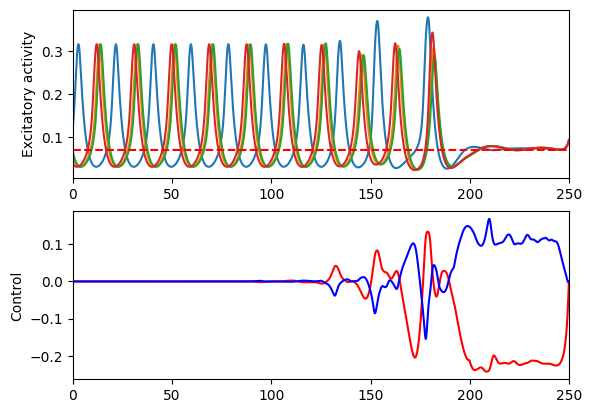

In [22]:
w2=1e-2
M_ = 80

model_controlled = oc_wc.OcWc(model, target_down, w_p=1, w_2=w2, print_array=np.arange(0,501,25), precision_cost_interval=(2000, None), M=M_, M_validation=400, random_init=init_ellipse)
model_controlled.optimize(100)
states = model_controlled.M_states
control = model_controlled.control

fname = "osc_down_w2_-2.png"
plot_random_init(model_controlled.model.t, states, target_down, control, fname)

w2=1e-1
model_controlled = oc_wc.OcWc(model, target_down, w_p=1, w_2=w2, print_array=np.arange(0,501,25), precision_cost_interval=(2000, None), M=M_, M_validation=400, random_init=init_ellipse)
model_controlled.optimize(100)
states = model_controlled.M_states
control = model_controlled.control

fname = "osc_down_w2_-1.png"
plot_random_init(model_controlled.model.t, states, target_down, control, fname)

Compute control for a noisy system
Mean cost in iteration 0: 0.6546390209674122
Mean cost in iteration 25: 0.10867827319608506
Mean cost in iteration 50: 0.0907530809332556
Mean cost in iteration 75: 0.07288783915100754
Mean cost in iteration 100: 0.056358632879935366
Mean cost in iteration 125: 0.04736812728102355
Mean cost in iteration 150: 0.04031813441001515
Mean cost in iteration 175: 0.03662494152533364
Mean cost in iteration 200: 0.03414372972979851
Mean cost in iteration 225: 0.03114858480554116
Mean cost in iteration 250: 0.028427981691502336
Mean cost in iteration 275: 0.027290582339949347
Mean cost in iteration 300: 0.026226072319892442
Mean cost in iteration 325: 0.02530519401170452
Mean cost in iteration 350: 0.024444244251828076
Mean cost in iteration 375: 0.02414437003856394
Mean cost in iteration 400: 0.023496967243483855
Mean cost in iteration 425: 0.023099347219056217
Mean cost in iteration 450: 0.022901243932242417
Mean cost in iteration 475: 0.02270446294544596
Mean

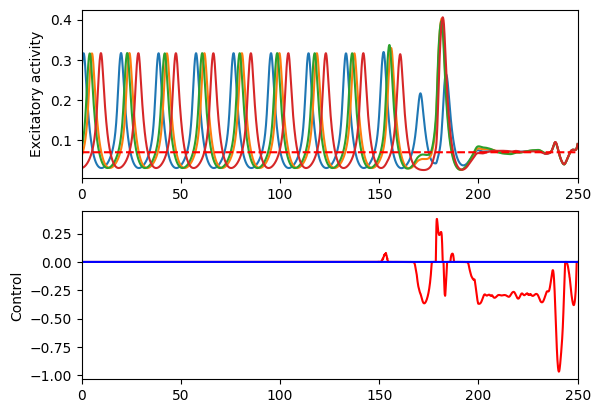

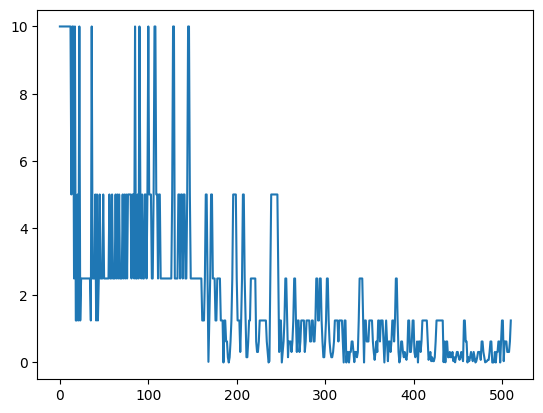

Compute control for a noisy system
Mean cost in iteration 0: 0.6457592132070832
Mean cost in iteration 25: 0.23979651277253522
Mean cost in iteration 50: 0.20550474463456841
Mean cost in iteration 75: 0.19220713855740526
Mean cost in iteration 100: 0.1843398091695882
Mean cost in iteration 125: 0.18031582733143078
Mean cost in iteration 150: 0.1752665080894484
Mean cost in iteration 175: 0.17091465271441467
Mean cost in iteration 200: 0.16985612484412854
Mean cost in iteration 225: 0.16800176190244565
Mean cost in iteration 250: 0.1659770877938312
Mean cost in iteration 275: 0.16586302777200956
Mean cost in iteration 300: 0.1647147947487869
Mean cost in iteration 325: 0.16307200078947945
Mean cost in iteration 350: 0.16311245930187498
Mean cost in iteration 375: 0.1619948224341776
Mean cost in iteration 400: 0.16214099549530508
Mean cost in iteration 425: 0.16007421759946833
Mean cost in iteration 450: 0.16212758606106306
Mean cost in iteration 475: 0.15937868425089835
Mean cost in ite

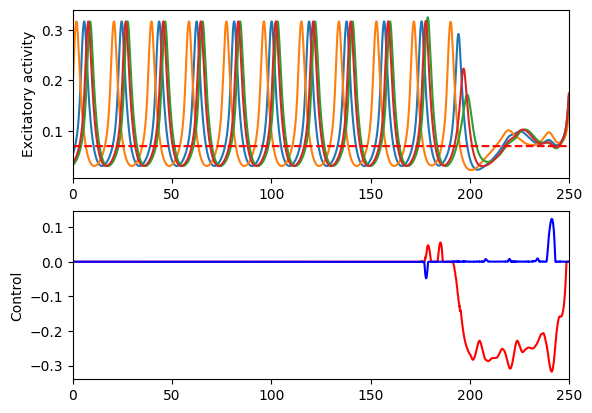

In [62]:
w1=1e-3
M_ = 80

c_mat = np.zeros((1,2))
c_mat[0,0] = 1.
model_controlled = oc_wc.OcWc(model, target_down, w_p=1, w_2 = 0., w_1=w1, print_array=np.arange(0,501,25), precision_cost_interval=(2000, None), control_matrix = c_mat, M=M_, M_validation=400, random_init=init_ellipse)
model_controlled.step = 1e1
model_controlled.optimize(500)

states = model_controlled.M_states
control = model_controlled.control
fname = "osc_down_w1_-3.png"
plot_random_init(model_controlled.model.t, states, target_down, control, fname)

plt.plot(model_controlled.step_sizes_history)
plt.show()

w1=1e-2
model_controlled = oc_wc.OcWc(model, target_down, w_p=1, w_2=0., w_1=w1, print_array=np.arange(0,501,25), precision_cost_interval=(2000, None), M=M_, M_validation=400, random_init=init_ellipse)
model_controlled.step = 1e1
model_controlled.optimize(500)

states = model_controlled.M_states
control = model_controlled.control
fname = "osc_down_w1_-2.png"
plot_random_init(model_controlled.model.t, states, target_down, control, fname)

Compute control for a noisy system
Mean cost in iteration 0: 0.6488814826769395
Mean cost in iteration 25: 0.1403048623988244
Mean cost in iteration 50: 0.07854001136997603
Mean cost in iteration 75: 0.040492734680837826
Mean cost in iteration 100: 0.027135614613763858
Mean cost in iteration 125: 0.025162630861499734
Mean cost in iteration 150: 0.02459786672208466
Mean cost in iteration 175: 0.024044419970642113
Mean cost in iteration 200: 0.023745103894028764
Mean cost in iteration 225: 0.02368388961147729
Mean cost in iteration 250: 0.02370218614120573
Mean cost in iteration 275: 0.02375565070598277
Mean cost in iteration 300: 0.023842853101067915
Mean cost in iteration 325: 0.023847864919862787
Mean cost in iteration 350: 0.023898952645989326
Mean cost in iteration 375: 0.02385942643758322
Mean cost in iteration 400: 0.02395079207317274
Mean cost in iteration 425: 0.02392167863160926
Mean cost in iteration 450: 0.02394688302860461
Mean cost in iteration 475: 0.02394253606062883
Mean

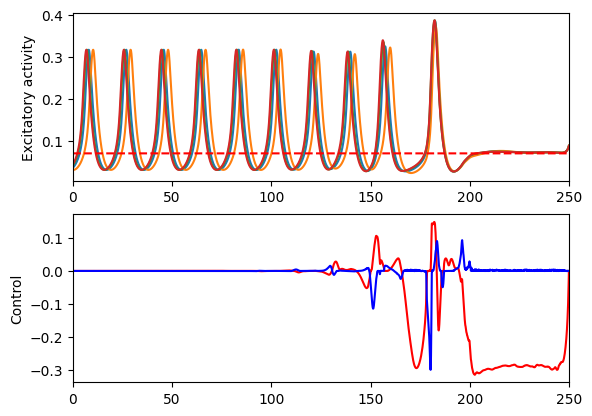

Compute control for a noisy system
Mean cost in iteration 0: 0.6441686248982903
Mean cost in iteration 25: 0.20586510048256654
Mean cost in iteration 50: 0.20623149122999948
Mean cost in iteration 75: 0.20506684738901826
Mean cost in iteration 100: 0.2049915658640998
Mean cost in iteration 125: 0.2042958481019997
Mean cost in iteration 150: 0.20497319710435424
Mean cost in iteration 175: 0.20525233831878106
Mean cost in iteration 200: 0.20472649342890126
Mean cost in iteration 225: 0.20574637758152153
Mean cost in iteration 250: 0.2055094062191932
Mean cost in iteration 275: 0.20529335107421312
Mean cost in iteration 300: 0.20597337297322035
Mean cost in iteration 325: 0.2051888260200196
Mean cost in iteration 350: 0.2048022909308052
Mean cost in iteration 375: 0.20551101207831093
Mean cost in iteration 400: 0.20613277454934348
Mean cost in iteration 425: 0.20645414640014242
Mean cost in iteration 450: 0.20621693528805413
Mean cost in iteration 475: 0.20588827602999965
Mean cost in ite

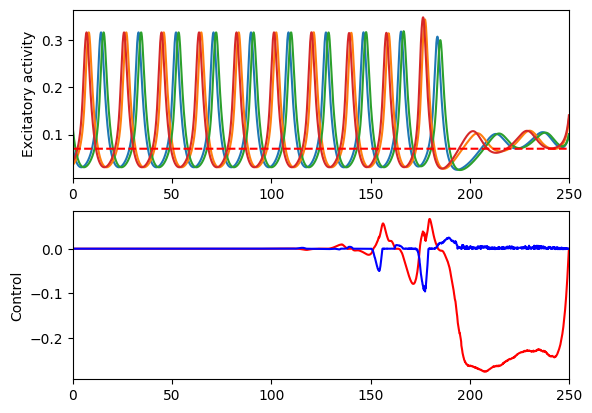

In [63]:
w1T=1e-2
M_ = 80
model_controlled = oc_wc.OcWc(model, target_down, w_p=1, w_2 = 0., w_1T=w1T, print_array=np.arange(0,501,25), precision_cost_interval=(2000, None), M=M_, M_validation=400, random_init=init_ellipse)
model_controlled.step = 1e1
model_controlled.optimize(600)

states = model_controlled.M_states
control = model_controlled.control
fname = "osc_down_w1T_-2.png"
plot_random_init(model_controlled.model.t, states, target_down, control, fname)

w1T=1e-1
model_controlled = oc_wc.OcWc(model, target_down, w_p=1, w_2=0., w_1T=w1T, print_array=np.arange(0,501,25), precision_cost_interval=(2000, None), M=M_, M_validation=400, random_init=init_ellipse)
model_controlled.step = 1e1
model_controlled.optimize(600)

states = model_controlled.M_states
control = model_controlled.control
fname = "osc_down_w1T_-1.png"
plot_random_init(model_controlled.model.t, states, target_down, control, fname)

Compute control for a noisy system
Mean cost in iteration 0: 0.6368116304197302
Mean cost in iteration 25: 0.22149006924044318
Mean cost in iteration 50: 0.16495401885414235
Mean cost in iteration 75: 0.15172000153910953
Mean cost in iteration 100: 0.14527689897454354
Mean cost in iteration 125: 0.140139375657944
Mean cost in iteration 150: 0.1346495295729862
Mean cost in iteration 175: 0.1314821883731086
Mean cost in iteration 200: 0.1280543240968986
Mean cost in iteration 225: 0.12528074755033453
Mean cost in iteration 250: 0.12246759244589005
Mean cost in iteration 275: 0.11969088598159272
Mean cost in iteration 300: 0.115930488846964
Mean cost in iteration 325: 0.1120175337920311
Mean cost in iteration 350: 0.10841900139595248
Mean cost in iteration 375: 0.10542293354767458
Mean cost in iteration 400: 0.10214898372084176
Mean cost in iteration 425: 0.0988330822306727
Mean cost in iteration 450: 0.09538610855704806
Mean cost in iteration 475: 0.09190665953078578
Mean cost in iterati

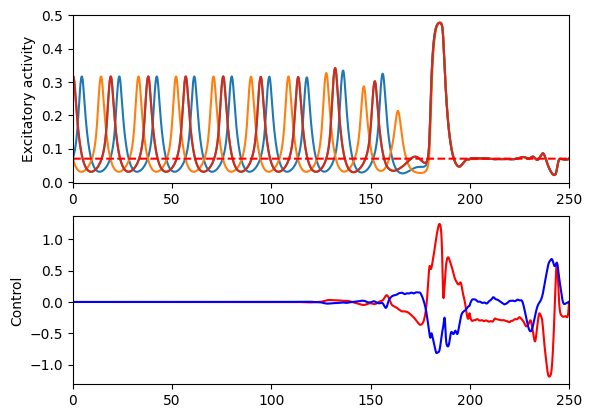

Compute control for a noisy system
Mean cost in iteration 0: 0.6279901829814697
Mean cost in iteration 25: 0.2476221296563667
Mean cost in iteration 50: 0.23376251679932353
Mean cost in iteration 75: 0.22849681579648262
Mean cost in iteration 100: 0.22736048901220768
Mean cost in iteration 125: 0.22790664703664737
Mean cost in iteration 150: 0.2279779633511224
Mean cost in iteration 175: 0.22813314599077397
Mean cost in iteration 200: 0.2282400512924815
Mean cost in iteration 225: 0.22833966159092195
Mean cost in iteration 250: 0.22842694339895142
Mean cost in iteration 275: 0.22842762972868402
Mean cost in iteration 300: 0.22858034311353928
Mean cost in iteration 325: 0.22862240409874923
Mean cost in iteration 350: 0.22873446881495493
Mean cost in iteration 375: 0.22867858120067092
Mean cost in iteration 400: 0.2288043323947672
Mean cost in iteration 425: 0.2290013237176475
Mean cost in iteration 450: 0.22883436981711677
Mean cost in iteration 475: 0.22895724992063776
Mean cost in ite

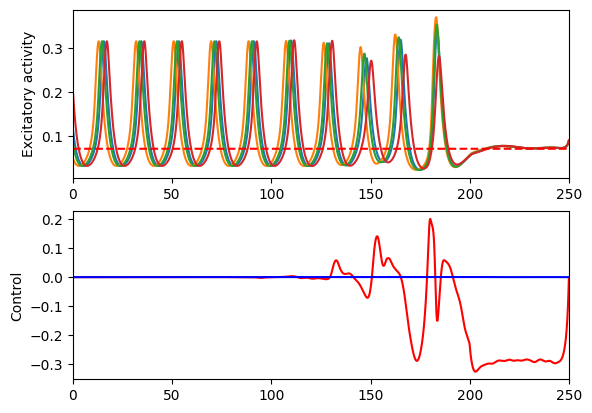

In [64]:
w1D=1e-2
M_ = 80
model_controlled = oc_wc.OcWc(model, target_down, w_p=1, w_2 = 0., w_1D=w1D, print_array=np.arange(0,501,25), precision_cost_interval=(2000, None), M=M_, M_validation=400, random_init=init_ellipse)
model_controlled.step = 1e1
model_controlled.optimize(600)

states = model_controlled.M_states
control = model_controlled.control
fname = "osc_down_w1D_-2.png"
plot_random_init(model_controlled.model.t, states, target_down, control, fname)

w1D=1e-1
model_controlled = oc_wc.OcWc(model, target_down, w_p=1, w_2 = 0., w_1D=w1D, print_array=np.arange(0,501,25), precision_cost_interval=(2000, None), M=M_, M_validation=400, random_init=init_ellipse)
model_controlled.step = 1e1
model_controlled.optimize(600)

states = model_controlled.M_states
control = model_controlled.control
fname = "osc_down_w1D_-1.png"
plot_random_init(model_controlled.model.t, states, target_down, control, fname)

In [22]:
savepath = '..' + os.sep + '..' + os.sep + '..' + os.sep + '..' + os.sep + 'writing' + os.sep + 'paper2_chaos' + os.sep + 'exploration' + os.sep + 'images' + os.sep

In [ ]:
w2=1e-1
M_ = 80

for int0 in np.arange(1750, 2001, 50):
    print("-----------------", int0/10)

    model_controlled = oc_wc.OcWc(model, target_osc, w_p=1, w_2=w2, print_array=np.arange(0,501,25), precision_cost_interval=(int0, None), M=M_, M_validation=400, random_init=init_ellipse)
    model_controlled.optimize(600)

    states = model_controlled.M_states
    control = model_controlled.control

    fname = "osc_phase_w2_-1_" + str(int(int0/10)) + ".png"

    plot_random_init(model_controlled.model.t, states, target_osc, control, os.path.join(savepath, fname))

----------------- 175.0
Compute control for a noisy system
Mean cost in iteration 0: 1.2745189166367823
Minimal cost found at iteration 0
Final cost validated with 1000 noise realizations : 1.2340582364302397
osc_phase_w2_-2_175


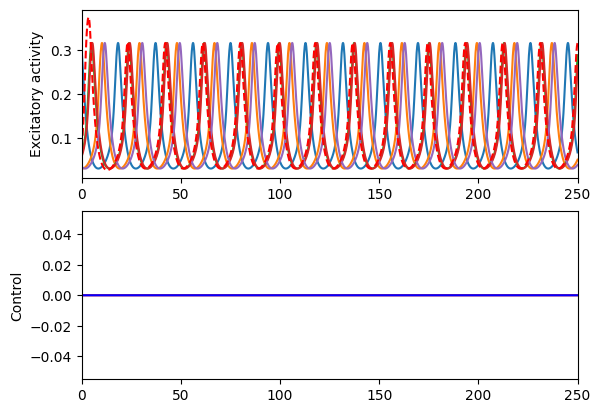

----------------- 180.0
Compute control for a noisy system
Mean cost in iteration 0: 1.1848559925151763
Minimal cost found at iteration 0
Final cost validated with 1000 noise realizations : 1.1696218709884285
osc_phase_w2_-2_180


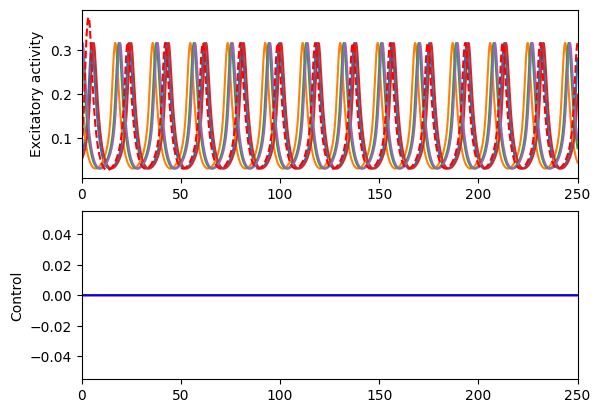

----------------- 185.0
Compute control for a noisy system
Mean cost in iteration 0: 1.064766606241508
Minimal cost found at iteration 0
Final cost validated with 1000 noise realizations : 1.1195360762118503
osc_phase_w2_-2_185


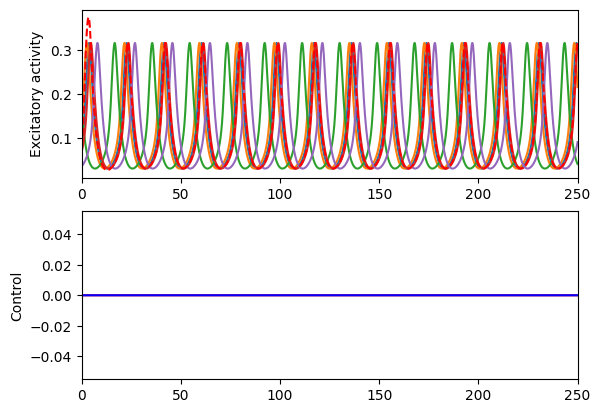

----------------- 190.0
Compute control for a noisy system
Mean cost in iteration 0: 1.0866147018214365
Minimal cost found at iteration 0
Final cost validated with 1000 noise realizations : 1.023851395599552
osc_phase_w2_-2_190


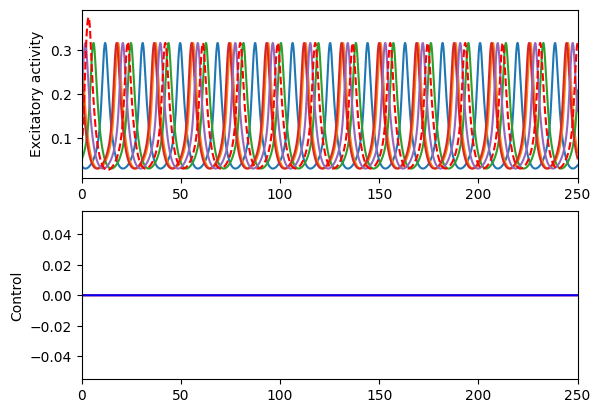

----------------- 195.0
Compute control for a noisy system
Mean cost in iteration 0: 0.8523952620911673
Minimal cost found at iteration 0


KeyboardInterrupt: 

In [78]:
w2=1e-2
M_ = 80

for int0 in np.arange(1750, 2001, 50):
    print("-----------------", int0/10)

    model_controlled = oc_wc.OcWc(model, target_osc, w_p=1, w_2=w2, print_array=np.arange(0,501,25), precision_cost_interval=(int0, None), M=M_, M_validation=400, random_init=init_ellipse)
    model_controlled.optimize(600)

    states = model_controlled.M_states
    control = model_controlled.control

    fname = "osc_phase_w2_-2_" + str(int(int0/10)) + ".png"

    plot_random_init(model_controlled.model.t, states, target_osc, control, os.path.join(savepath, fname))

In [ ]:
int0_array = np.arange(1750, 2001, 50)
states_w1_min2 = [None] * len(int0_array)
controls_w1_min2 = [None] * len(int0_array)

----------------- 175.0
----------------- 180.0
----------------- 185.0
----------------- 190.0
----------------- 195.0
----------------- 200.0
Compute control for a noisy system
Mean cost in iteration 0: 0.06925358176595156
Mean cost in iteration 25: 0.06898323759315089
Mean cost in iteration 50: 0.0684180868729446
Mean cost in iteration 75: 0.06843425668016681
Mean cost in iteration 100: 0.06818134380723567
Minimal cost found at iteration 48
Final cost validated with 400 noise realizations : 0.06840076574967113


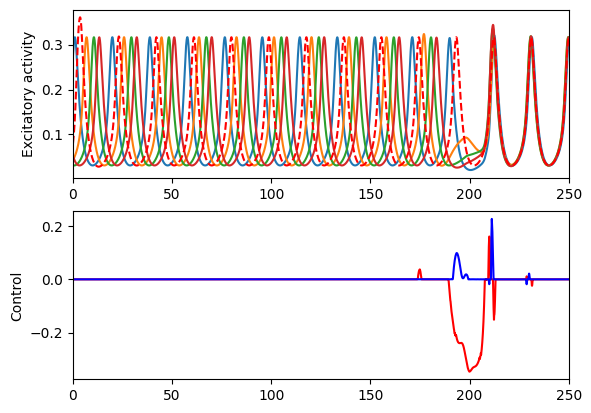

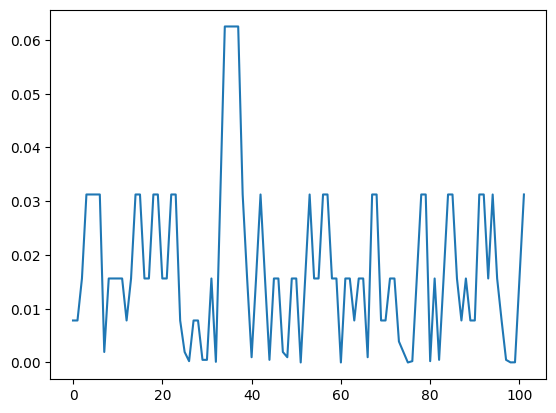

In [32]:
###### OK

w1=1e-2
M_ = 80

for i in range(len(int0_array)):
    int0 = int0_array[i]
    print("-----------------", int0/10)

    if int0 in [1750, 1800, 1850, 1900, 1950]:
        continue

    model_controlled = oc_wc.OcWc(model, target_osc, w_p=1, w_2=0., w_1=w1, print_array=np.arange(0,1001,25), precision_cost_interval=(int0, None), M=M_, M_validation=400, random_init=init_ellipse)
    model_controlled.step = 0.25

    if type(states_w1_min2[i]) != type(None):
        model_controlled.control = controls_w1_min2[i].copy()
        model_controlled.update_input()

    model_controlled.optimize(100)

    states_w1_min2[i] = model_controlled.M_states
    controls_w1_min2[i] = model_controlled.control

    fname = "osc_phase_w1_-2_" + str(int(int0/10)) + ".png"

    plot_random_init(model_controlled.model.t, states_w1_min2[i], target_osc, controls_w1_min2[i], os.path.join(savepath, fname))

    plt.plot(model_controlled.step_sizes_history)
    plt.show()

In [33]:
states_w1_min1 = [None] * len(int0_array)
controls_w1_min1 = [None] * len(int0_array)

----------------- 175.0
----------------- 180.0
----------------- 185.0
----------------- 190.0
----------------- 195.0
----------------- 200.0
Compute control for a noisy system
Mean cost in iteration 0: 0.46523001127547936
Mean cost in iteration 25: 0.48523376687797015
Mean cost in iteration 50: 0.49077597141130325
Mean cost in iteration 75: 0.46445023873287383
Mean cost in iteration 100: 0.5000139877763866
Minimal cost found at iteration 19
Final cost validated with 400 noise realizations : 0.4725972709907056


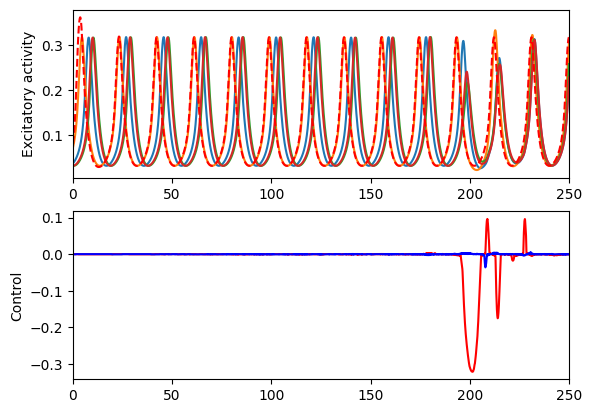

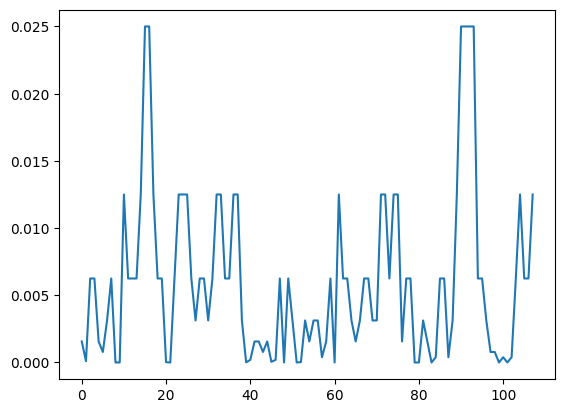

In [38]:
### OK

w1=1e-1

for i in range(len(int0_array)):
    int0 = int0_array[i]
    print("-----------------", int0/10)

    if int0 in [1750, 1800, 1850, 1900, 1950]:
        continue

    model_controlled = oc_wc.OcWc(model, target_osc, w_p=1, w_2=0., w_1=w1, print_array=np.arange(0,1001,25), precision_cost_interval=(int0, None), M=M_, M_validation=400, random_init=init_ellipse)
    model_controlled.step = 0.1

    if type(states_w1_min1[i]) != type(None):
        model_controlled.control = controls_w1_min1[i].copy()
        model_controlled.update_input()

    model_controlled.optimize(100)

    states_w1_min1[i] = model_controlled.M_states
    controls_w1_min1[i] = model_controlled.control

    fname = "osc_phase_w1_-1_" + str(int(int0/10)) + ".png"

    plot_random_init(model_controlled.model.t, states_w1_min1[i], target_osc, controls_w1_min1[i], os.path.join(savepath, fname))

    plt.plot(model_controlled.step_sizes_history)
    plt.show()

In [39]:
states_w1T_min2 = [None] * len(int0_array)
controls_w1T_min2 = [None] * len(int0_array)

----------------- 175.0
----------------- 180.0
----------------- 185.0
----------------- 190.0
Compute control for a noisy system
Mean cost in iteration 0: 0.6411496579926934
Mean cost in iteration 100: 0.6379136754563739
Minimal cost found at iteration 16
Final cost validated with 400 noise realizations : 0.6110660732640741


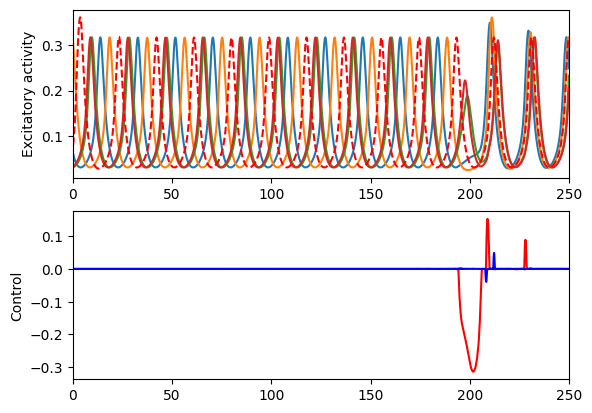

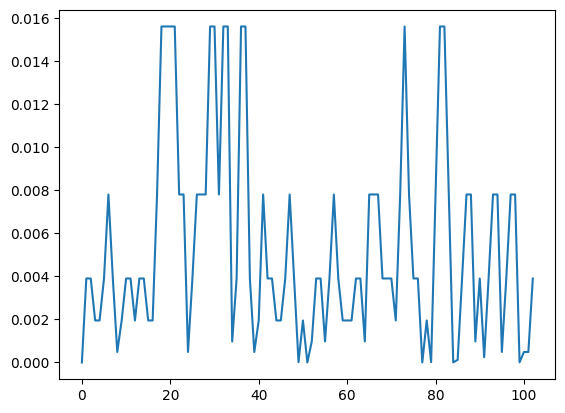

----------------- 195.0
----------------- 200.0


In [44]:
## OK

w1T=1e-2
M_ = 80

for i in range(len(int0_array)):
    int0 = int0_array[i]
    print("-----------------", int0/10)

    if int0 in [1750, 1800, 1850, 1950, 2000]:
        continue

    model_controlled = oc_wc.OcWc(model, target_osc, w_p=1, w_2=0., w_1=w1, print_array=np.arange(0,1001,100), precision_cost_interval=(int0, None), M=M_, M_validation=400, random_init=init_ellipse)
    model_controlled.step = 1.

    if type(states_w1T_min2[i]) != type(None):
        model_controlled.control = controls_w1T_min2[i].copy()
        model_controlled.update_input()

    model_controlled.optimize(100)

    states_w1T_min2[i] = model_controlled.M_states
    controls_w1T_min2[i] = model_controlled.control

    fname = "osc_phase_w1T_-2_" + str(int(int0/10)) + ".png"

    plot_random_init(model_controlled.model.t, states_w1T_min2[i], target_osc, controls_w1T_min2[i], os.path.join(savepath, fname))

    plt.plot(model_controlled.step_sizes_history)
    plt.show()

----------------- 175.0
Compute control for a noisy system
Mean cost in iteration 0: 1.3048230325454713
Mean cost in iteration 25: 0.2071151063090389
Mean cost in iteration 50: 0.14855403488497174
Mean cost in iteration 75: 0.13962805081989615
Mean cost in iteration 100: 0.1326112689083011
Mean cost in iteration 125: 0.12473902160212894
Mean cost in iteration 150: 0.1250104708962087
Mean cost in iteration 175: 0.1339192785960727
Mean cost in iteration 200: 0.12935722603136948
Mean cost in iteration 225: 0.12598086280697196
Mean cost in iteration 250: 0.13075435780400066
Mean cost in iteration 275: 0.12657586784662936
Mean cost in iteration 300: 0.12025773021617166
Mean cost in iteration 325: 0.12700285335500044
Mean cost in iteration 350: 0.12772798225752163
Mean cost in iteration 375: 0.1250524448575953
Mean cost in iteration 400: 0.12455679007110987
Mean cost in iteration 425: 0.12711414124658993
Mean cost in iteration 450: 0.12412964423864123
Mean cost in iteration 475: 0.1222868953

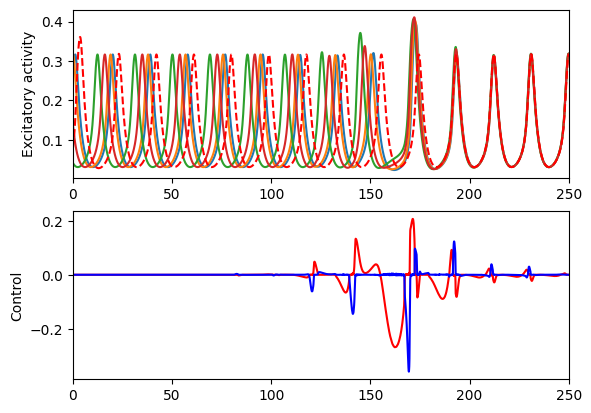

----------------- 180.0
Compute control for a noisy system
Mean cost in iteration 0: 1.181755256018399
Mean cost in iteration 25: 0.2419682171635878
Mean cost in iteration 50: 0.15617864443757407
Mean cost in iteration 75: 0.14251319815893151
Mean cost in iteration 100: 0.13862675897610002
Mean cost in iteration 125: 0.13784208676648013
Mean cost in iteration 150: 0.13808582434187286
Mean cost in iteration 175: 0.13676109426323307
Mean cost in iteration 200: 0.1361299556096803
Mean cost in iteration 225: 0.13778519670978223
Mean cost in iteration 250: 0.1358720366095784
Mean cost in iteration 275: 0.13798689598760616
Mean cost in iteration 300: 0.1380353381489891
Mean cost in iteration 325: 0.13666355079214582
Mean cost in iteration 350: 0.13901671476486105
Mean cost in iteration 375: 0.13709983209423654
Mean cost in iteration 400: 0.13807421182346283
Mean cost in iteration 425: 0.13695935490807074
Mean cost in iteration 450: 0.13809857383994023
Mean cost in iteration 475: 0.1377996101

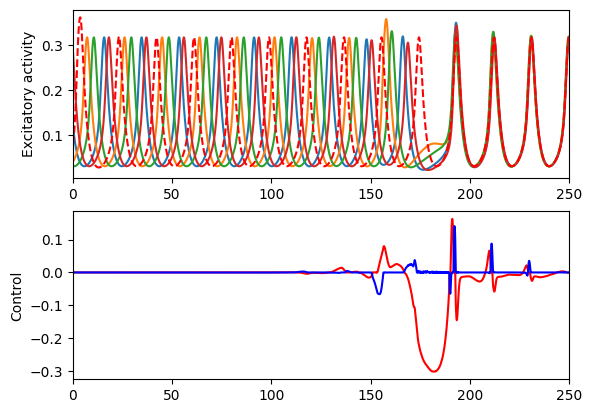

----------------- 185.0
Compute control for a noisy system
Mean cost in iteration 0: 1.0990289280771939
Mean cost in iteration 25: 0.16243293543421317
Mean cost in iteration 50: 0.12623850457610894
Mean cost in iteration 75: 0.1219019383116007
Mean cost in iteration 100: 0.1237590351990678
Mean cost in iteration 125: 0.12050690670272626
Mean cost in iteration 150: 0.12052503894959639
Mean cost in iteration 175: 0.12225977609184462
Mean cost in iteration 200: 0.12232820604094737
Mean cost in iteration 225: 0.12191816194491092
Mean cost in iteration 250: 0.12514168841746626
Mean cost in iteration 275: 0.126072858291917
Mean cost in iteration 300: 0.12418244603850696
Mean cost in iteration 325: 0.12284192297881033
Mean cost in iteration 350: 0.12560874729960342
Mean cost in iteration 375: 0.1263498798504254
Mean cost in iteration 400: 0.12559257246539682
Mean cost in iteration 425: 0.12508011723655865
Mean cost in iteration 450: 0.12658217486877063
Mean cost in iteration 475: 0.1248388351

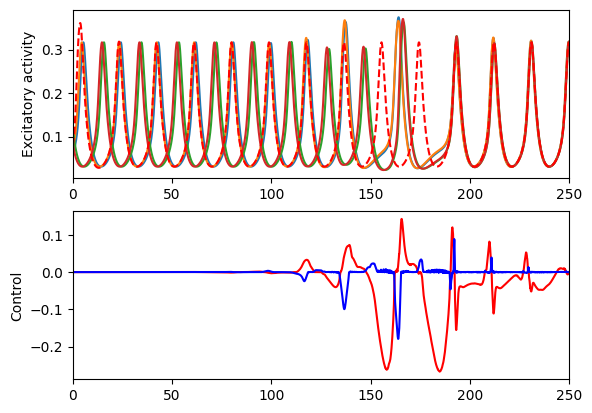

----------------- 190.0
Compute control for a noisy system
Mean cost in iteration 0: 1.1069903104932532
Mean cost in iteration 25: 0.12712834230529485
Mean cost in iteration 50: 0.10687759382671577
Mean cost in iteration 75: 0.10583593533547782
Mean cost in iteration 100: 0.10953439044574889
Mean cost in iteration 125: 0.10618284223330714
Mean cost in iteration 150: 0.10875981417796446
Mean cost in iteration 175: 0.10967037442762491
Mean cost in iteration 200: 0.10957242285697141
Mean cost in iteration 225: 0.10940508438376954
Mean cost in iteration 250: 0.11181262330618029
Mean cost in iteration 275: 0.11219840268259404
Mean cost in iteration 300: 0.11157745642786514
Mean cost in iteration 325: 0.11028089955446137
Mean cost in iteration 350: 0.11366113855779567
Mean cost in iteration 375: 0.11056254896713638
Mean cost in iteration 400: 0.1121802853469285
Mean cost in iteration 425: 0.11081749981294275
Mean cost in iteration 450: 0.11290436373764086
Mean cost in iteration 475: 0.112719

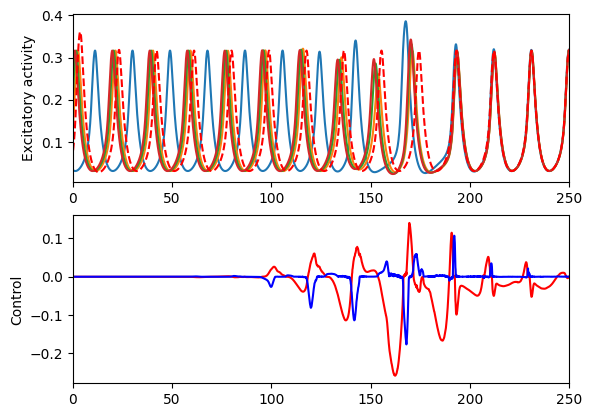

----------------- 195.0
Compute control for a noisy system
Mean cost in iteration 0: 0.988675264906443
Mean cost in iteration 25: 0.18605792382291286
Mean cost in iteration 50: 0.19041631669088266
Mean cost in iteration 75: 0.19893948540263812
Mean cost in iteration 100: 0.19243481887331604
Mean cost in iteration 125: 0.19417355339116035
Mean cost in iteration 150: 0.18734303034813693
Mean cost in iteration 175: 0.18752027332479407
Mean cost in iteration 200: 0.1779520086011706
Mean cost in iteration 225: 0.1820346252868354
Mean cost in iteration 250: 0.18301690071797502
Mean cost in iteration 275: 0.18980750482803385
Mean cost in iteration 300: 0.18606720067040397
Mean cost in iteration 325: 0.1760399407140062
Mean cost in iteration 350: 0.1845827763105066
Mean cost in iteration 375: 0.18291287618724006
Mean cost in iteration 400: 0.18256807743366354
Mean cost in iteration 425: 0.19995871819001415
Mean cost in iteration 450: 0.18287874590166
Mean cost in iteration 475: 0.1850107356586

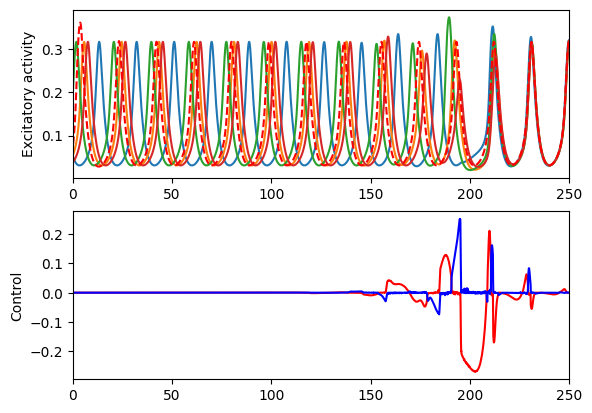

----------------- 200.0
Compute control for a noisy system
Mean cost in iteration 0: 0.8175903928047081
Mean cost in iteration 25: 0.135345310064671
Mean cost in iteration 50: 0.13134694655318702
Mean cost in iteration 75: 0.13165224247086396
Mean cost in iteration 100: 0.1326701383895092
Mean cost in iteration 125: 0.1311509261697729
Mean cost in iteration 150: 0.13209126450660597
Mean cost in iteration 175: 0.1329389871238939
Mean cost in iteration 200: 0.13215501827798437
Mean cost in iteration 225: 0.13261094486206143
Mean cost in iteration 250: 0.13294339683556544
Mean cost in iteration 275: 0.13344310164008444
Mean cost in iteration 300: 0.13456343811801202
Mean cost in iteration 325: 0.134310857820622
Mean cost in iteration 350: 0.1336051634129179
Mean cost in iteration 375: 0.13321344938770044
Mean cost in iteration 400: 0.13210617572948474
Mean cost in iteration 425: 0.13463589329436718
Mean cost in iteration 450: 0.13439869363679974
Mean cost in iteration 475: 0.1330762827164

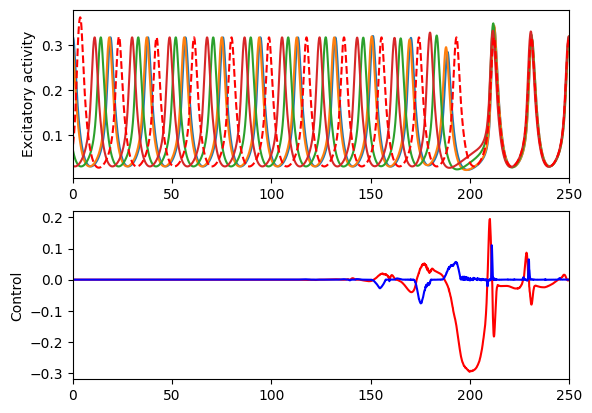

In [9]:
######## OK

w1T=1e-1
M_ = 80

for int0 in np.arange(1750, 2001, 50):
    print("-----------------", int0/10)

    model_controlled = oc_wc.OcWc(model, target_osc, w_p=1, w_2=0., w_1T=w1T, print_array=np.arange(0,501,25), precision_cost_interval=(int0, None), M=M_, M_validation=400, random_init=init_ellipse)
    model_controlled.optimize(600)

    states = model_controlled.M_states
    control = model_controlled.control

    fname = "osc_phase_w1T_-1_" + str(int(int0/10)) + ".png"

    plot_random_init(model_controlled.model.t, states, target_osc, control, os.path.join(savepath, fname))

In [45]:
states_w1D_min2 = [None] * len(int0_array)
controls_w1D_min2 = [None] * len(int0_array)

----------------- 175.0
----------------- 180.0
----------------- 185.0
----------------- 190.0
----------------- 195.0
----------------- 200.0
Compute control for a noisy system
Mean cost in iteration 0: 0.4659704231095689
Mean cost in iteration 25: 0.47998730955832203
Mean cost in iteration 50: 0.46313083908055414
Mean cost in iteration 75: 0.5004098832017265
Mean cost in iteration 100: 0.47481226714730973
Minimal cost found at iteration 40
Final cost validated with 400 noise realizations : 0.46896921939011976


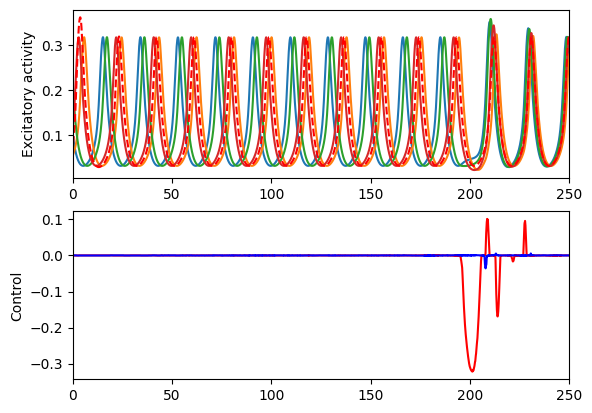

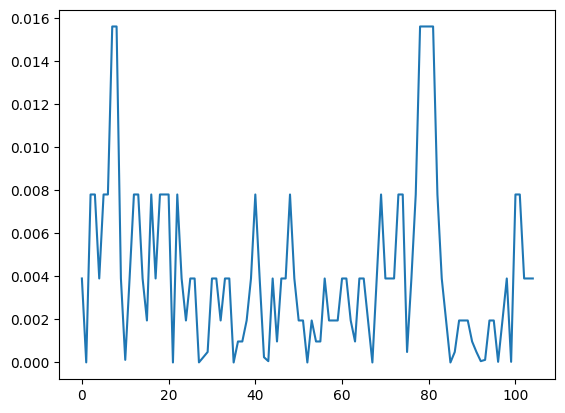

In [51]:

####OK
w1D=1e-2
M_ = 80

for i in range(len(int0_array)):
    int0 = int0_array[i]
    print("-----------------", int0/10)

    if int0 in [1750, 1800, 1850, 1900, 1950, 200]:
        continue

    model_controlled = oc_wc.OcWc(model, target_osc, w_p=1, w_2=0., w_1=w1, print_array=np.arange(0,1001,25), precision_cost_interval=(int0, None), M=M_, M_validation=400, random_init=init_ellipse)
    model_controlled.step = 1.

    if type(states_w1D_min2[i]) != type(None):
        model_controlled.control = controls_w1D_min2[i].copy()
        model_controlled.update_input()

    model_controlled.optimize(100)

    states_w1D_min2[i] = model_controlled.M_states
    controls_w1D_min2[i] = model_controlled.control

    fname = "osc_phase_w1D_-2_" + str(int(int0/10)) + ".png"

    plot_random_init(model_controlled.model.t, states_w1D_min2[i], target_osc, controls_w1D_min2[i], os.path.join(savepath, fname))

    plt.plot(model_controlled.step_sizes_history)
    plt.show()

In [52]:
states_w1D_min1 = [None] * len(int0_array)
controls_w1D_min1 = [None] * len(int0_array)

----------------- 175.0
----------------- 180.0
----------------- 185.0
Compute control for a noisy system
Mean cost in iteration 0: 0.7138334358017685
Mean cost in iteration 25: 0.6829578189073626
Mean cost in iteration 50: 0.6576926489343473
Mean cost in iteration 75: 0.6885465049908204
Mean cost in iteration 100: 0.75877021863699
Minimal cost found at iteration 11
Final cost validated with 400 noise realizations : 0.6971816967981717


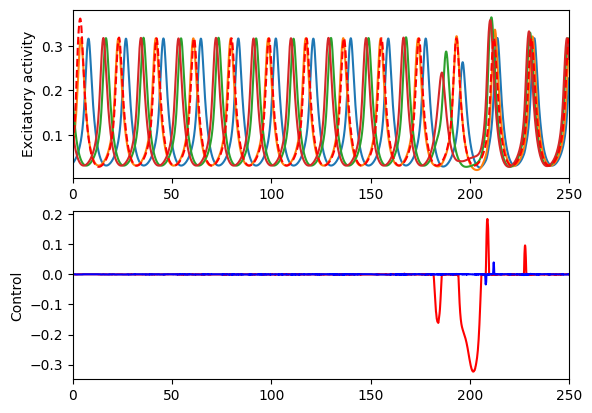

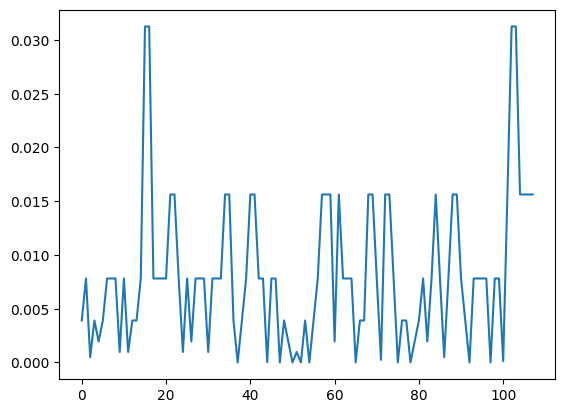

----------------- 190.0
Compute control for a noisy system
Mean cost in iteration 0: 0.6281820597477408
Mean cost in iteration 25: 0.6149897131486703
Mean cost in iteration 50: 0.6229423390349556
Mean cost in iteration 75: 0.6697286946480119
Mean cost in iteration 100: 0.609328780629343
Minimal cost found at iteration 57
Final cost validated with 400 noise realizations : 0.6181252928411919


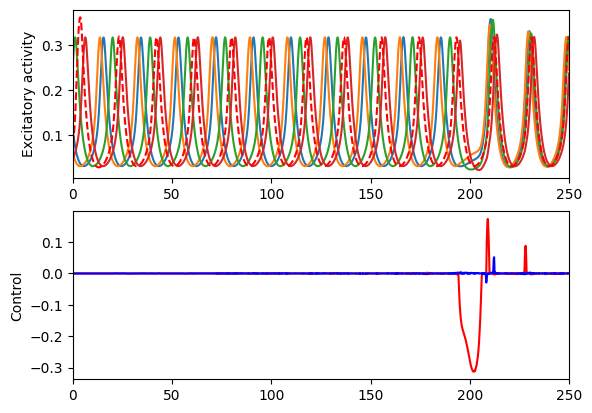

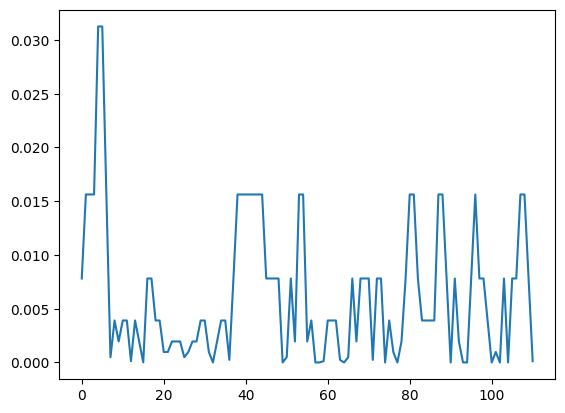

----------------- 195.0
----------------- 200.0


In [56]:
### OK

w1D=1e-1
M_ = 80

for i in range(len(int0_array)):
    int0 = int0_array[i]
    print("-----------------", int0/10)

    if int0 in [1750, 1800, 1950, 2000]:
        continue

    model_controlled = oc_wc.OcWc(model, target_osc, w_p=1, w_2=0., w_1=w1, print_array=np.arange(0,1001,25), precision_cost_interval=(int0, None), M=M_, M_validation=400, random_init=init_ellipse)
    model_controlled.step = 1.

    if type(states_w1D_min1[i]) != type(None):
        model_controlled.control = controls_w1D_min1[i].copy()
        model_controlled.update_input()

    model_controlled.optimize(100)

    states_w1D_min1[i] = model_controlled.M_states
    controls_w1D_min1[i] = model_controlled.control

    fname = "osc_phase_w1D_-1_" + str(int(int0/10)) + ".png"

    plot_random_init(model_controlled.model.t, states_w1D_min1[i], target_osc, controls_w1D_min1[i], os.path.join(savepath, fname))

    plt.plot(model_controlled.step_sizes_history)
    plt.show()